## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# 1. Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [2]:
import gc # сборщик мусора
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.linear_model import LogisticRegression #1
from sklearn.svm import SVC                         #2
!pip install xgboost
import xgboost as xgb # 6

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier #3

from sklearn.ensemble import RandomForestRegressor #4
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

!pip install lightgbm
from lightgbm import LGBMRegressor #5



%matplotlib inline

In [3]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Загрузка данных**

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


#### Обзор данных

In [5]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [6]:
df_train.index

RangeIndex(start=0, stop=7500, step=1)

In [7]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Fill NaN

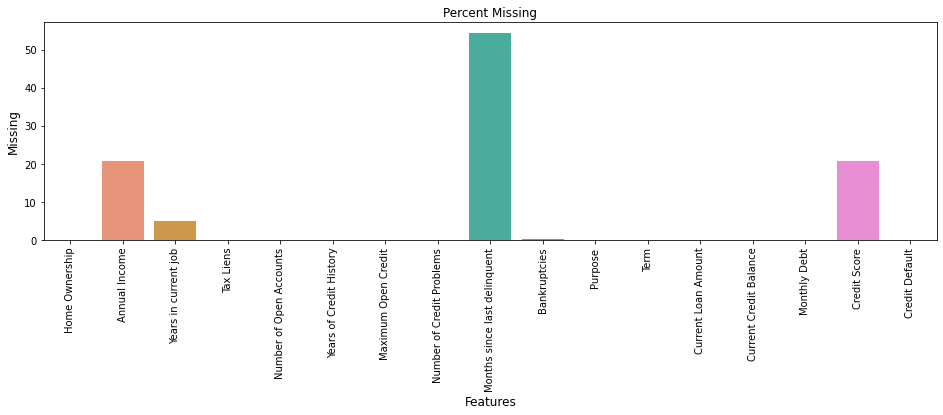

In [8]:
nan_df1 = (100*(df_train.isna().sum()) / df_train.shape[0]).reset_index()
nan_df1.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df1['feature'], nan_df1['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

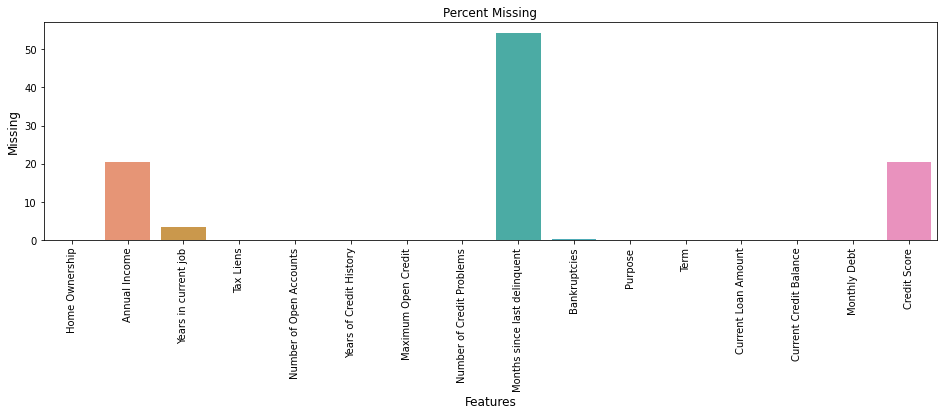

In [9]:
nan_df2 = (100*(df_test.isna().sum()) / df_test.shape[0]).reset_index()
nan_df2.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df2['feature'], nan_df2['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Выбросы

Current Loan Amount (оставляю миллиардеров как есть)

### Test df

In [10]:
df_test.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [11]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

# 2. Очистка данных

In [12]:
X_train = df_train.drop('Credit Default', axis=1)
y_train = df_train[['Credit Default']]
X_test = df_test
#y_test = df_test[['Credit Default']]

In [13]:
class FeatureImputerTrain:
    """Заполнение пропусков и подготовка категориальных данных"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X_train):
        self.medians = X_train.median()
    
    def transform(self, X_train):
        
        # Annual Income
        X_train.loc[X_train['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        
        # Months since last delinquent
        X_train.loc[X_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = X_train['Months since last delinquent'].quantile(0.8)
        
         # Credit Score 
        X_train.loc[X_train['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        
        # Bankruptcies
        X_train.loc[X_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0
        X_train.loc[X_train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
        
        # Tax Liens
        X_train.loc[X_train['Tax Liens'] > 0, 'Tax Liens'] = 1
        
        
        # Number of Credit Problems
        X_train.loc[X_train['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 2
        
        # Years in current job
        X_train.loc[X_train['Years in current job'].isna(), 'Years in current job'] = 0
        X_train.loc[(X_train['Years in current job'] == '< 1 year') | (X_train['Years in current job'] == '1 year') | (X_train['Years in current job'] == '2 years'), 'Years in current job'] = 1
        X_train.loc[(X_train['Years in current job'] == '3 years') | (X_train['Years in current job'] == '4 years') | (X_train['Years in current job'] == '5 years'), 'Years in current job'] = 2
        X_train.loc[(X_train['Years in current job'] == '6 years') | (X_train['Years in current job'] == '7 years') | (X_train['Years in current job'] == '8 years'), 'Years in current job'] = 3
        X_train.loc[(X_train['Years in current job'] == '9 years') | (X_train['Years in current job'] == '10+ years'), 'Years in current job'] = 4
        
         
    
        
        return X_train
        

In [14]:
class FeatureImputerTest:
    """Заполнение пропусков и подготовка категориальных данных"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X_test):
        self.medians = X_train.median()
    
    def transform(self, X_test):
        
        # Annual Income
        X_test.loc[X_test['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        
        # Months since last delinquent
        X_test.loc[X_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = X_train['Months since last delinquent'].quantile(0.8)
        
         # Credit Score 
        X_test.loc[X_test['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        
        # Bankruptcies
        X_test.loc[X_test['Bankruptcies'].isna(), 'Bankruptcies'] = 0
        X_test.loc[X_test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
        
        # Tax Liens
        X_test.loc[X_test['Tax Liens'] > 0, 'Tax Liens'] = 1
        
        
        # Number of Credit Problems
        X_test.loc[X_test['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 2
        
        # Years in current job
        X_test.loc[X_test['Years in current job'].isna(), 'Years in current job'] = 0
        X_test.loc[(X_test['Years in current job'] == '< 1 year') | (X_test['Years in current job'] == '1 year') | (X_test['Years in current job'] == '2 years'), 'Years in current job'] = 1
        X_test.loc[(X_test['Years in current job'] == '3 years') | (X_test['Years in current job'] == '4 years') | (X_test['Years in current job'] == '5 years'), 'Years in current job'] = 2
        X_test.loc[(X_test['Years in current job'] == '6 years') | (X_test['Years in current job'] == '7 years') | (X_test['Years in current job'] == '8 years'), 'Years in current job'] = 3
        X_test.loc[(X_test['Years in current job'] == '9 years') | (X_test['Years in current job'] == '10+ years'), 'Years in current job'] = 4
        
         
    
        
        return X_test
        

In [15]:
imputerTrain = FeatureImputerTrain()
imputerTest = FeatureImputerTest()

imputerTrain.fit(X_train)
imputerTest.fit(X_test)

X_train = imputerTrain.transform(X_train)
X_test = imputerTest.transform(X_test)

In [16]:
X_test.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1168386.0,2,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,2,0.0,10.0,13.7,204600.0,0.0,56.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,4,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,3,0.0,11.0,23.6,1207272.0,0.0,56.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


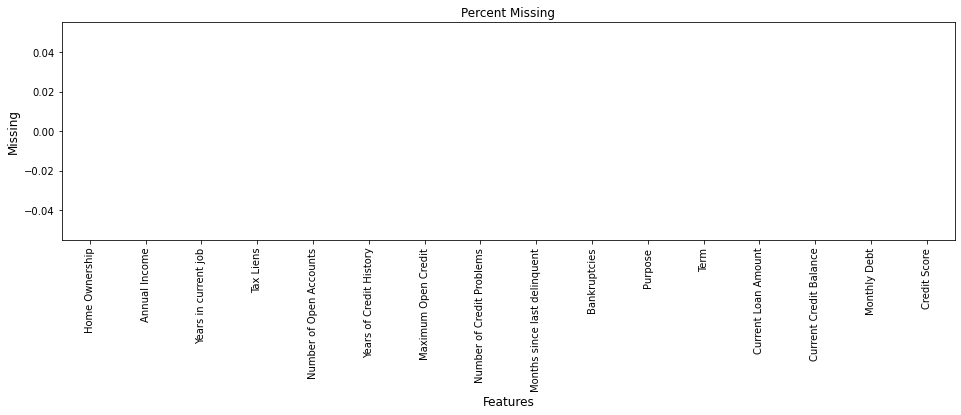

In [17]:
nan_df11 = (100*(X_train.isna().sum()) / X_train.shape[0]).reset_index()
nan_df11.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df11['feature'], nan_df11['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

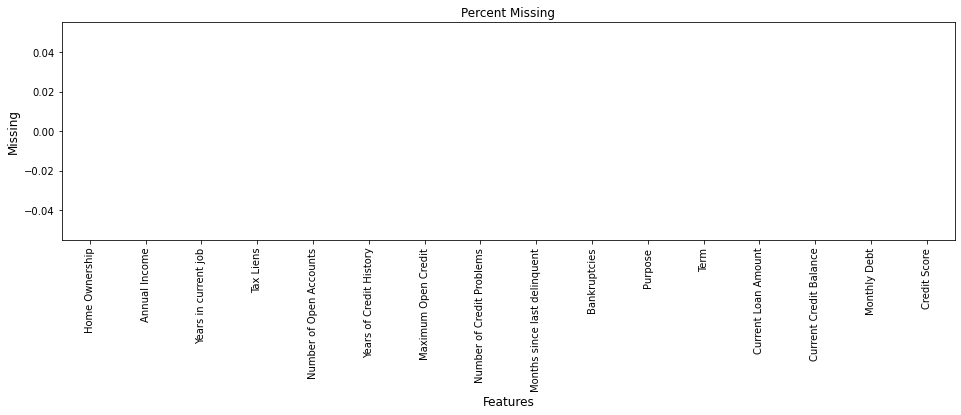

In [18]:
nan_df22 = (100*(X_test.isna().sum()) / X_test.shape[0]).reset_index()
nan_df22.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df22['feature'], nan_df22['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# 3. Feature engineering

## Categorical

In [19]:
X_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

To category - Home Ownership obj, Tax Liens num, Purpose obj, Terms obj, Number of Credit Problems num, Bankruptcies num, Years in current job obj

Numeric

In [19]:
#Train
X_train['Tax Liens'] = X_train['Tax Liens'].astype('category')
X_train['Number of Credit Problems'] = X_train['Number of Credit Problems'].astype('category')
X_train['Bankruptcies'] = X_train['Bankruptcies'].astype('category')
#Test
X_test['Tax Liens'] = X_test['Tax Liens'].astype('category')
X_test['Number of Credit Problems'] = X_test['Number of Credit Problems'].astype('category')
X_test['Bankruptcies'] = X_test['Bankruptcies'].astype('category')

Object

In [20]:
#Train
X_train['Purpose'] = X_train['Purpose'].astype('category')
X_train['Home Ownership'] = X_train['Home Ownership'].astype('category')
X_train['Years in current job'] = X_train['Years in current job'].astype('category')
X_train['Term'] = X_train['Term'].astype('category')
#Test
X_test['Purpose'] = X_test['Purpose'].astype('category')
X_test['Home Ownership'] = X_test['Home Ownership'].astype('category')
X_test['Years in current job'] = X_test['Years in current job'].astype('category')
X_test['Term'] = X_test['Term'].astype('category')

In [23]:
        # Get dummies
X_test = pd.get_dummies(X_test)       
X_train = pd.get_dummies(X_train)
X_train.dtypes

Annual Income                    float64
Number of Open Accounts          float64
Years of Credit History          float64
Maximum Open Credit              float64
Months since last delinquent     float64
Current Loan Amount              float64
Current Credit Balance           float64
Monthly Debt                     float64
Credit Score                     float64
Home Ownership_Have Mortgage       uint8
Home Ownership_Home Mortgage       uint8
Home Ownership_Own Home            uint8
Home Ownership_Rent                uint8
Years in current job_0             uint8
Years in current job_1             uint8
Years in current job_2             uint8
Years in current job_3             uint8
Years in current job_4             uint8
Tax Liens_0.0                      uint8
Tax Liens_1.0                      uint8
Number of Credit Problems_0.0      uint8
Number of Credit Problems_1.0      uint8
Number of Credit Problems_2.0      uint8
Bankruptcies_0.0                   uint8
Bankruptcies_1.0

# 4. Модель

### LGBMRegressor

In [47]:
lgbmr = LGBMRegressor(max_depth=7,
                             num_leaves = 20,
                             n_estimators=150,
                             random_state=42)

In [98]:
lgbmr.fit(X_train2, y_train)

LGBMRegressor(max_depth=7, n_estimators=150, num_leaves=20, random_state=42)

In [99]:
y_pred4 = lgbmr.predict(X_train2)
#y_test_pred = lgbmr.predict(X_test)

In [100]:
# Returns a NumPy Array
check_test2 = pd.DataFrame({
    "y_train": y_train["Credit Default"],
    "y_pred": y_pred4.round().flatten(),
})

check_test2.tail(10)

,y_train,y_pred
7490,1,1.0
7491,0,0.0
7492,0,0.0
7493,1,1.0
7494,0,0.0
7495,0,0.0
7496,1,1.0
7497,0,-0.0
7498,0,0.0
7499,0,0.0


In [101]:
f1_score(y_train, y_pred4.round())

0.6646077825818406

In [107]:
repLGB = classification_report(y_train, y_pred4.round(), output_dict=True)
reportLGB = pd.DataFrame(repLGB).transpose()
reportLGB

,precision,recall,f1-score,support
0,0.837333,0.990904,0.907669,5387.0000
1,0.956444,0.509229,0.664608,2113.0000
accuracy,0.855200,0.855200,0.855200,0.8552
macro avg,0.896889,0.750066,0.786138,7500.0000
weighted avg,0.870891,0.855200,0.839190,7500.0000


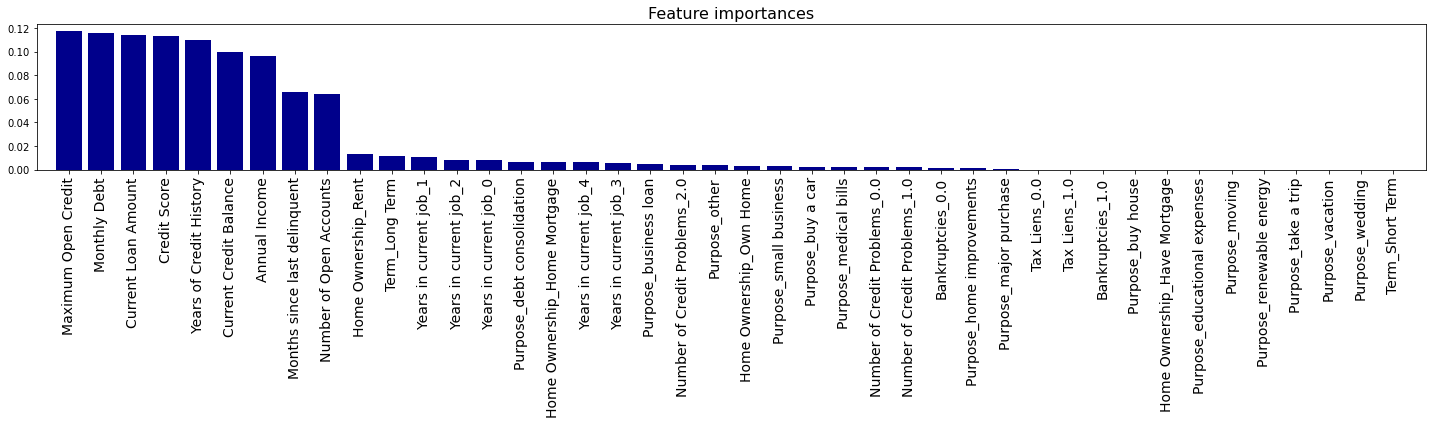

In [122]:
def plot_feature_importances(importances, X_train2): #LGBMRegressor
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X_train2.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X_train2.shape[1]), X_train2.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X_train2.shape[1]])

    plt.tight_layout()
    plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = lgbmr.feature_importances_, X_train2=X_train2)

In [123]:
X_train2.columns

Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0',
       'Years in current job_1', 'Years in current job_2',
       'Years in current job_3', 'Years in current job_4', 'Tax Liens_0.0',
       'Tax Liens_1.0', 'Number of Credit Problems_0.0',
       'Number of Credit Problems_1.0', 'Number of Credit Problems_2.0',
       'Bankruptcies_0.0', 'Bankruptcies_1.0', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy',

In [134]:
remain_features = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_0',
       'Years in current job_1', 'Years in current job_2',
       'Years in current job_3', 'Years in current job_4',
       'Number of Credit Problems_2.0',
       'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_debt consolidation',
       'Purpose_other', 'Purpose_small business',
       'Term_Long Term']

X_lgbmr = X_train2[remain_features]

In [135]:
lgbmr.fit(X_lgbmr, y_train)
y_pred9 = lgbmr.predict(X_lgbmr)

In [136]:
# Returns a NumPy Array
check_test9 = pd.DataFrame({
    "y_train": y_train["Credit Default"],
    "y_pred": y_pred9.round().flatten(),
})

check_test9.tail(10)

,y_train,y_pred
7490,1,0.0
7491,0,0.0
7492,0,0.0
7493,1,1.0
7494,0,0.0
7495,0,0.0
7496,1,1.0
7497,0,-0.0
7498,0,0.0
7499,0,0.0


In [137]:
repLGB2 = classification_report(y_train, y_pred4.round(), output_dict=True)
reportLGB2 = pd.DataFrame(repLGB2).transpose()
reportLGB2

,precision,recall,f1-score,support
0,0.837333,0.990904,0.907669,5387.0000
1,0.956444,0.509229,0.664608,2113.0000
accuracy,0.855200,0.855200,0.855200,0.8552
macro avg,0.896889,0.750066,0.786138,7500.0000
weighted avg,0.870891,0.855200,0.839190,7500.0000


## KNeighbours Classifier

In [103]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train2, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [104]:
y_pred6 = neigh.predict(X_train2)

In [105]:
# Returns a NumPy Array
check_test2 = pd.DataFrame({
    "y_train": y_train["Credit Default"],
    "y_pred": y_pred6.flatten(),
})

check_test2.tail(10)

,y_train,y_pred
7490,1,0
7491,0,1
7492,0,0
7493,1,1
7494,0,0
7495,0,0
7496,1,1
7497,0,0
7498,0,0
7499,0,0


In [106]:
f1_score(y_train, y_pred6)

0.6331923890063424

In [108]:
repKNN = classification_report(y_train, y_pred6.round(), output_dict=True)
reportKNN = pd.DataFrame(repKNN).transpose()
reportKNN

,precision,recall,f1-score,support
0,0.843026,0.912196,0.876248,5387.000000
1,0.716936,0.566966,0.633192,2113.000000
accuracy,0.814933,0.814933,0.814933,0.814933
macro avg,0.779981,0.739581,0.754720,7500.000000
weighted avg,0.807502,0.814933,0.807771,7500.000000


First, select good parameters. Try to: use small num_leaves (I think that is the most useful way), small feature_fraction or bagging_fraction, or add lambda_l1 or l2, etc. Check for here for more advice from official documentation.

Second, use early stopping. If you set number of iterations very high, it is very possible to be over-fitting. Early stopping means when the performance of validation set can't improve for several rounds, stop iterating. Check part 4 in my kernel to use early stopping with LightGBM API

Thirdly, although you set good parameters, it is also very possible that test performance (leaderboard) is not as good as validation. Here I will suggest using Kfold cross validation to train k model and take average. I learn this from @olivier, and here is his kernel

Finally, whatever we do, train performance should typically be higher than any other. What we want is to improve our validation performance and make it in line with leaderboard score.